In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils
import Modeling.modeling_utils.datasets as ds
import Modeling.modeling_utils.model_architectures as arch

Load data

In [2]:
#open and combine all data
key = 'BTCUSD'
full_df = pd.read_csv(os.path.join('..', '..', 'data', 'scraped_OHLC_4-28-2024', key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df.dropna(inplace=True, axis=0, how='all')

In [3]:
full_df

,open,high,low,close,vwap,volume,count
dtime,,,,,,,
2022-04-13 17:33:00,41054.5,41054.5,41054.5,41054.5,41054.5,0.609958,9
2022-04-13 17:34:00,41054.5,41054.5,41000.0,41000.0,41031.2,0.778243,29
2022-04-13 17:35:00,41000.0,41001.6,40991.8,41001.5,40996.8,0.697326,16
2022-04-13 17:36:00,41001.6,41001.6,40950.2,40950.2,40972.5,1.606614,17
2022-04-13 17:37:00,40950.1,40950.2,40933.2,40933.2,40936.6,0.043350,9
...,...,...,...,...,...,...,...
2024-04-29 03:24:00,62654.2,62662.1,62654.2,62662.0,62661.6,0.149024,16
2024-04-29 03:25:00,62662.1,62667.1,62662.1,62667.1,62662.1,0.090850,8
2024-04-29 03:26:00,62667.1,62667.1,62667.0,62667.1,62667.0,0.001626,3


investigate quartile dataset

In [4]:
in_window_size = 60*48
out_window_size = 60*4
batch_size = 64
train_test_split = 0.9
out_key = 'close' #, 'SOLUSD_close', 'DOTUSD_close', 'ADAUSD_close', 'ALGOUSD_close']

dataset = ds.quartile_dataset(full_df, in_window_size, out_winsize=out_window_size, out_key=out_key, in_keys=None, num_quartiles=10, debug=True)

Quartiles: [-0.08944588 -0.03531462  0.00432852  0.02392371  0.03555043  0.04574645
  0.06195504  0.08741792  0.11215639  0.1358807   0.27058405]


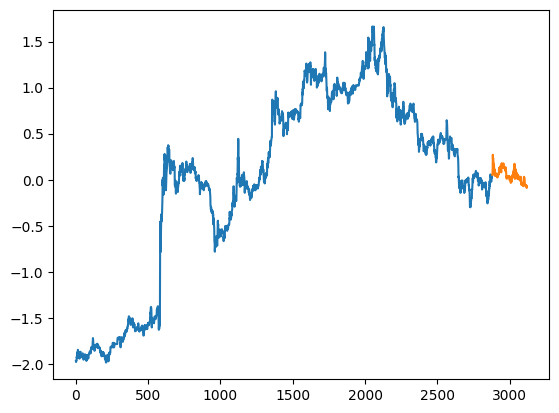

In [5]:
#plot random sample
rand_idx = np.random.randint(0, len(dataset))

x, y, _y = dataset[rand_idx]
plt.plot(np.arange(len(x[3])), x[3])

#also plot future segment and print the quartiles
plt.plot(np.arange(len(x[3]), len(x[3])+len(_y)), _y)

print('Quartiles:', y.numpy())

build train and test datasets

In [6]:
in_window_size = 60*24
out_window_size = 60*4
batch_size = 32
train_test_split = 0.8
out_key = 'close' #, 'SOLUSD_close', 'DOTUSD_close', 'ADAUSD_close', 'ALGOUSD_close']
num_quartiles = 6

#for reshaping
window_size = 60
stride = 15

train_ds = ds.quartile_dataset(df=full_df[0:int(.8*len(full_df))], in_winsize=in_window_size, out_winsize=out_window_size, out_key=out_key, in_keys=None, num_quartiles=num_quartiles)
test_ds = ds.quartile_dataset(df=full_df[int(.8*len(full_df)):], in_winsize=in_window_size, out_winsize=out_window_size, out_key=out_key, in_keys=None, num_quartiles=num_quartiles)

reshaped_train_ds = ds.Multichannel_1d_to_2d_wrapper(train_ds, window_size = window_size, stride=stride)
reshaped_test_ds = ds.Multichannel_1d_to_2d_wrapper(test_ds, window_size = window_size, stride=stride)

downsampled_reshaped_train_ds = ds.RandomDownsampleDataset(reshaped_train_ds, out_size=5000, method='random')
downsampled_reshaped_test_ds = ds.RandomDownsampleDataset(reshaped_test_ds, out_size=500, method='random')
    
train_dl = DataLoader(downsampled_reshaped_train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(downsampled_reshaped_test_ds, batch_size=batch_size, shuffle=True)

In [7]:
downsampled_reshaped_train_ds[0][0].shape, downsampled_reshaped_train_ds[0][1].shape

(torch.Size([7, 93, 60]), torch.Size([7]))

In [8]:
itrtr = iter(train_dl)
x, y = next(itrtr)
x.shape, y.shape

(torch.Size([32, 7, 93, 60]), torch.Size([32, 7]))

In [9]:
 #test encoder on dataloader
# model = arch.get_resnet(input_chans=7, output_size=y.shape[1], pretrained=True)
model = arch.custom_CNN2d(out_dim=y.shape[1])
x, y = next(iter(train_dl))
x = x.to(torch.float32)
y_hat = model(x)

# model = Encoder(4)
# y = model(next(iter(train_dataloader)))
y_hat.shape, y.shape

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([32, 7]), torch.Size([32, 7]))

In [10]:
def train_loop(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        x, y = data
        x = x.to(torch.float32)
        x = x.to(device)  # Move the inputs to the device (GPU or CPU)
        
        y = y.to(torch.float32)
        y = y.to(device)    
        optimizer.zero_grad()  # Zero the parameter gradients

        y_hat = model(x)  # Forward pass
        loss = criterion(y_hat, y)  # Compute the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.detach().item()
        print(f"Train epoch: Percent complete: {100 * i / len(dataloader)}, Current loss: {loss}", end='\r')
    return running_loss / len(dataloader)

    
def val_loop(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            x, y = data
            x = x.to(torch.float32)
            x = x.to(device)  # Move the inputs to the device (GPU or CPU)
            y = y.to(torch.float32)
            y = y.to(device)
            y_hat = model(x)  # Forward pass
            loss = criterion(y_hat, y)  # Compute the loss

            running_loss += loss.detach().item()
            print(f"Val epoch: Percent complete: {100 * i / len(dataloader)}", end='\r')

    return running_loss / len(dataloader)

val_losses = []
train_losses = []

In [12]:
num_epochs = 40
learning_rate = .000003
loss_fn = nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
for epoch in range(num_epochs):
    train_loss = train_loop(model, train_dl, loss_fn, optimizer, device)
    val_loss = val_loop(model, test_dl, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    downsampled_reshaped_train_ds.next_indecies()
    downsampled_reshaped_test_ds.next_indecies()
    
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

Epoch 1/40, Train Loss: 3.715165465500704, Val Loss: 3.4504592940211296391201019287
Epoch 2/40, Train Loss: 3.730585770242533, Val Loss: 3.6913808584213257849517822277
Epoch 3/40, Train Loss: 4.045256840195625, Val Loss: 4.2203127965331086145858764655
Epoch 4/40, Train Loss: 3.4137150736371424, Val Loss: 3.149923596531152708175659256
Epoch 5/40, Train Loss: 3.890642781166514, Val Loss: 3.0965258255600938070812225348
Epoch 6/40, Train Loss: 3.442266849195881, Val Loss: 2.2369890064001083525695800786
Epoch 7/40, Train Loss: 3.7969684836211477, Val Loss: 3.795068360865116211246490487
Epoch 8/40, Train Loss: 3.4622915231498186, Val Loss: 3.706643246114254302925109868
Epoch 9/40, Train Loss: 3.8108668205844367, Val Loss: 4.522107169032097456848144537
Epoch 10/40, Train Loss: 3.3597246848853533, Val Loss: 3.63979828357696531919097917
Epoch 11/40, Train Loss: 3.536604427228308, Val Loss: 3.885882444679737971305847175
Epoch 12/40, Train Loss: 3.872529004789462, Val Loss: 3.14693155884742745813

KeyboardInterrupt: 

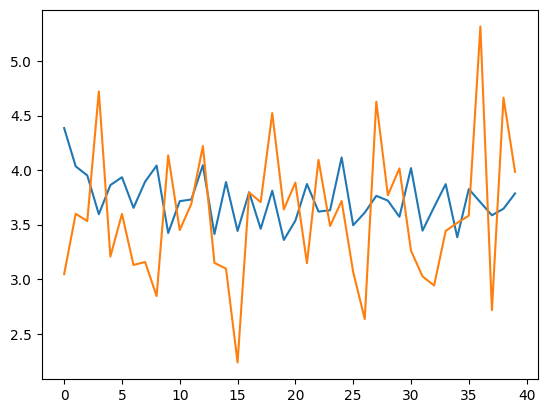

In [13]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

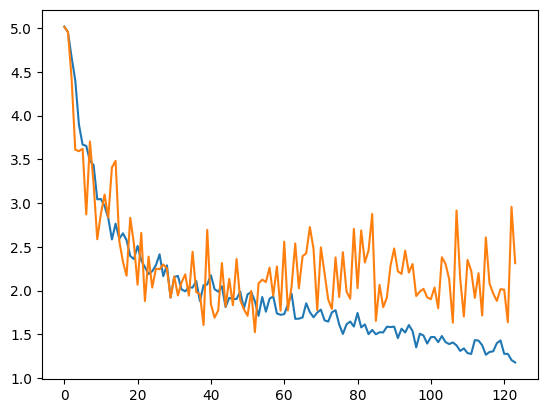

In [15]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

In [16]:
#save model
save_folder = r'C:\Users\avido\Documents\other code\AlgoTrading\Modeling\model_checkpoints'
torch.save(model, os.path.join(save_folder, 'resnet_encoder_6_quartiles_120epochs.pth'))

Show some examples from the test set

In [19]:
# load model
save_folder = r'C:\Users\avido\Documents\other code\AlgoTrading\Modeling\model_checkpoints'
model = torch.load(os.path.join(save_folder, 'resnet_encoder_6_quartiles_2epochs.pth'))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
test_ds_debug = ds.quartile_dataset(df=full_df[int(.9*len(full_df)):], in_winsize=in_window_size, out_winsize=out_window_size, out_key=out_key, in_keys=None, num_quartiles=num_quartiles, debug=True)

Quartiles: [1.38098235 1.98624142 2.20235044 2.60661441 2.97737362 3.5023149
 3.91691117]
Predicted: [[-1.6624118 -1.5408789 -1.4063891 -1.5401087 -1.6997852 -1.2607591
  -1.2557275]]


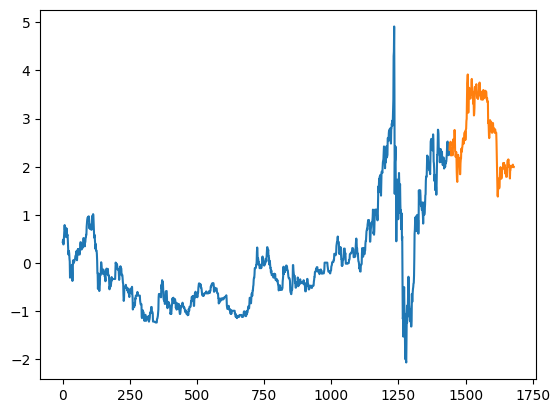

In [33]:
#plot random sample
rand_idx = np.random.randint(0, len(test_ds_debug))

x, y, _y = test_ds_debug[rand_idx]
plt.plot(np.arange(len(x[3])), x[3])

#also plot future segment and print the quartiles
plt.plot(np.arange(len(x[3]), len(x[3])+len(_y)), _y)

print('Quartiles:', y.numpy())

model.eval()
x, y = reshaped_test_ds[rand_idx]
y_hat = model(x.to(device).unsqueeze(0).to(torch.float32))
print('Predicted:', y_hat.detach().cpu().numpy())